# HURST_RC MODELS ARTICLE CODE RESULTS.



In [1]:
# If you are using colab, run this cell before running the other cells below

# Download the pyESN repository

!git clone https://github.com/cknd/pyESN.git

# Copy the pyESN.py file to the current directory
!cp pyESN/pyESN.py .


# Importing the libraries

!pip install hurst
!pip install yfinance
!pip install nolds
#!pip install git+https://github.com/cknd/pyESN.git
import pyESN
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from pyESN import ESN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from hurst import compute_Hc
import nolds


Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106 (from 1)
Receiving objects: 100% (106/106), 1.17 MiB | 4.49 MiB/s, done.
Resolving deltas: 100% (53/53), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 2.2 MB/s eta 0:00:00


# SOURCE CODE. TO RUN THEM, JUST ADJUST THE DESIRED ASSET, THE PARAMETERS AND THE DESIRED PERIOD.

[*********************100%***********************]  1 of 1 completed



MSE: 14497.790407881856
MAE: 98.68182330894406
R²: 0.9951056660978983
MAPE: 0.4008217068377147
RMSE: 120.40677060648149


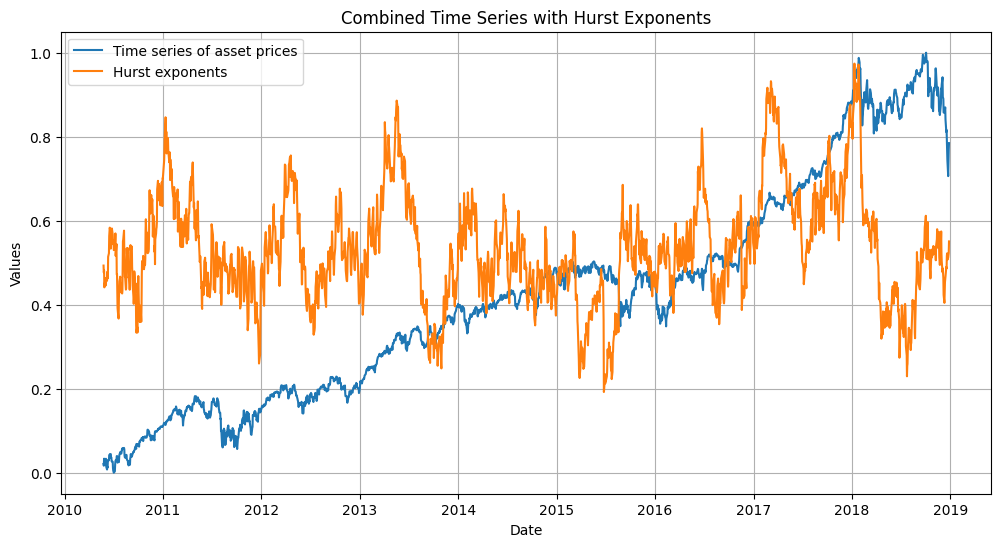

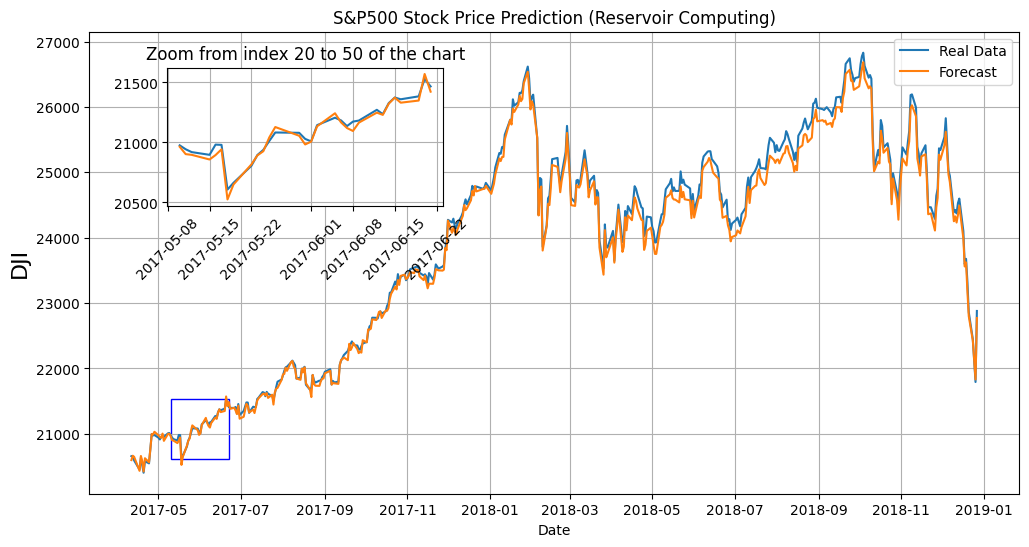

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from pyESN import ESN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from hurst import compute_Hc
import nolds

# Setting a random seed to ensure reproducibility
np.random.seed(42)

# Loading Yahoo Finance (S&P500) data
ticker = "^DJI"
data = yf.download(ticker, start="2009-12-31", end="2018-12-28")
series = data["Close"].values.reshape(-1, 1)

# Data normalization
scaler = MinMaxScaler()
normalized_series = scaler.fit_transform(series)

# Configuring Reservoir Computing parameters
reservoir_size = 200
sparsity = 0.2
noise = 0.1
spectral_radius = 0.7



# Sliding window size
window_size = 100
hurst_exponents = []
lyapunov_results = []
katz_fractal_dimensions = []

# Calculating Hurst Exponents.

for i in range(0, len(normalized_series) - window_size + 1):
    interval_data = normalized_series[i:i+window_size]

    hurst_exponent, _, _ = compute_Hc(interval_data.reshape(-1))
    hurst_exponents.append(hurst_exponent)




hurst_exponents = np.array(hurst_exponents).reshape(-1, 1)


# Rescaling the time series to be the same size as the Hurst Exponents

normalized_series = normalized_series[-len(hurst_exponents):]

# Creating tables with the Hurst Exponent

hurst_table = pd.DataFrame({'Interval': np.arange(len(hurst_exponents)), 'Hurst exponent': hurst_exponents[:, 0]})

# Concatenating Hurst Exponents and Time Series Data
data_combined = np.hstack((normalized_series, hurst_exponents))

# Updating the training set size
train_size = int(len(data_combined) * 0.8)

# Splitting data into training and testing
train_data = data_combined[:train_size]
test_data = data_combined[train_size:]

# Checking if there is enough training data
if len(train_data) == 0:
    raise ValueError("Não há dados de treinamento suficientes.")

# Model training
esn = ESN(n_inputs=data_combined.shape[1], n_outputs=1, n_reservoir=reservoir_size, sparsity=sparsity, noise=noise, spectral_radius=spectral_radius)
esn.fit(train_data[:-1, :], train_data[1:, 0])

# Forecast
test_input = test_data[:-1, :]
predicted_output = esn.predict(test_input)

# Denormalization of forecasts
predicted_output = scaler.inverse_transform(predicted_output.reshape(-1, 1))

# Denormalization of test data
test_data = scaler.inverse_transform(test_data[:-1, :-1])

# Calculation of evaluation metrics
mse = mean_squared_error(test_data[:, 0], predicted_output)
mae = mean_absolute_error(test_data[:, 0], predicted_output)
r2 = r2_score(test_data[:, 0], predicted_output)

# Calculation of MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test_data[:, 0] - predicted_output[:, 0]) / test_data[:, 0])) * 100

# Calculation of RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Printing evaluation metrics
print("\nMSE:", mse)
print("MAE:", mae)
print("R²:", r2)
print("MAPE:", mape)
print("RMSE:", rmse)

# Plotting the graph with the concatenated data
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index[-len(data_combined):], data_combined[:, 0], label="Time series of asset prices")

# Plot Hurst exponents
ax.plot(data.index[-len(data_combined):], data_combined[:, 1], label="Hurst exponents")

ax.set_xlabel("Date")
ax.set_ylabel("Values")
ax.set_title("Combined Time Series with Hurst Exponents")
ax.legend()
ax.grid(True)

plt.show()



# Plotting the forecast graph with zoom
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index[-len(test_data):], test_data[:, 0], label="Real Data")
ax.plot(data.index[-len(test_data):], predicted_output, label="Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("DJI", fontsize=16)
ax.set_title("S&P500 Stock Price Prediction (Reservoir Computing)" )
ax.legend()
ax.grid(True) # disable this part to not print the mesh

# Defining x and y axis limits for zooming

start_index = 20  # Starting index for zoom
end_index = 50  # Final index for zoom

# Chart configuration (zoom position on chart)
inset_ax = fig.add_axes([0.19, 0.59, 0.23, 0.23], aspect='auto')  # Adjust these values ​​as needed to position the zoom graph
inset_ax.plot(data.index[-len(test_data):][start_index:end_index], test_data[start_index:end_index, 0], label="Real Data")
inset_ax.plot(data.index[-len(test_data):][start_index:end_index], predicted_output[start_index:end_index], label="Forecast")
inset_ax.set_title('Zoom from index 20 to 50 of the chart')
inset_ax.grid(True) # disable this part to not print the mesh
inset_ax.set_aspect('auto')

# Rotating the x-axis labels
for tick in inset_ax.get_xticklabels():
    tick.set_rotation(45)

# Defining rectangle to highlight zoom area in main graph
rect = plt.Rectangle((data.index[-len(test_data):][start_index], min(test_data[start_index:end_index, 0])),
                     (data.index[-len(test_data):][end_index] - data.index[-len(test_data):][start_index]),
                     (max(test_data[start_index:end_index, 0]) - min(test_data[start_index:end_index, 0])),
                     edgecolor='blue', facecolor='none')
ax.add_patch(rect)

plt.show()


